In [285]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from time import time
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import os
from PIL import Image
import time
from torch import nn, optim
import torch.nn.functional as F

# SLIDE (1) CrossEntropyLoss

Задача **простая**, просто текста много, чтобы все все поняли.

Напишем совю loss-функцию кроссэнтропии для многоклассовой классификации.

Пусть 
* $y_i^{real}$ - реальный класс $i$-го объекта, скаляр
* $p_i$ - вектор вероятностей каждого класса размера $C$ (кол-во классов)

Классы обозначаются числами $0, 1, \ldots, C-1$. Вероятность $k$-го класса $p_i^k$ находится на $k$-м месте $p_i[k]$.

Тогда кроссэнтропия для одного объекта будет считаться так:

$$CrossEntropy(p_i, y_i^{real}) = -\sum_{k=0}^{C-1}[y_i^{real} = k]\log{(p_i[k])}$$

где $[y_i^{real} = k]$ - индикатор, что индекс вектора совпадает с реальным классом.


В этой сумме будет только один ненулевой элемент, поэтому можно переписать как

$$CrossEntropy(p_i, y_i^{real}) = -\log{(p_i[y_i^{real}])}$$

Берем предсказание соответствующее нужному классу.


Тогда кроссентропия по объектам в батче запишется как 

$$ L(P, y^{real}) = -{\frac1{|B|}} \sum_{i=1}^{B}\log{(p_i[y_i^{real}])} $$

, где $B$ - размер батча.


Но нейросеть нам возвращает не вероятности, а логиты, и вероятности сначала еще нужно получить, через софтмакс:)

Пусть $x_i$ - выход нейронки: вектор длины $C$ (логиты). Тогда вероятности можно получить как

$$p_i^k = \frac{e^{x_i[k]}}{\sum_{c = 0}^{C-1}e^{x_i[c]}}$$

Собрав все воедино получим

$$ L(X, y^{real}) = -{\frac1{|B|}} \sum_{i=1}^{B}\log{\Big(\frac{e^{x_i[y_i^{real}]}}{\sum_{c = 0}^{C-1}e^{x_i[c]}}\Big)} $$

На вход вам подается матрица логитов $X$ и классы $y^{real}$.

Надо посчитать кроссэнтропию.


`Примечание:` Софтмакс может сломаться, если вы ему передадите слишком большой логит: $e^{100}$ - очень больно. Поэтому воспользуемся небольшим трюком. Зная, что $\text{softmax}(x) == \text{softmax}(x - \text{const})$ мы вычтем максимум из логитов и будем работать с измененными логитами.
Эта операция сделана за вас в первой строчке. Удалять ее не нужно.

# TASK

In [ ]:
def loss(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    logits -= torch.max(logits, axis=1)[0]
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    pass

In [ ]:
######################################################
assert torch.allclose(loss(torch.tensor([[100.,0.0]]), 
                           torch.tensor([0])), 
                      torch.tensor([0.]))
######################################################
assert torch.allclose(loss(torch.tensor([[100.,100.0]]), 
                           torch.tensor([0])), 
                      torch.tensor([0.6931]), atol=1e-3)
######################################################
assert torch.allclose(loss(torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.]]), 
                           torch.tensor([4])), 
                      torch.tensor([3.458]), atol=1e-3)
######################################################
assert torch.allclose(loss(torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.]]), 
                           torch.tensor([5])), 
                      torch.tensor([2.458]), atol=1e-3)
######################################################
assert torch.allclose(loss(torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.],
                                         [1.,2.,3.,4.,5.,6.,7.,8.],
                                         [1.,2.,3.,4.,5.,6.,7.,8.],
                                         [1.,2.,3.,4.,5.,6.,7.,8.]]), 
                           torch.tensor([1,2,3,7])), 
                      torch.tensor([4.208]), atol=1e-3)


# SLIDE (2) Свертка

В этой задаче вам требуется написать своими руками операцию свертки 3x3 для 3-х канальной картинки. 

Операция производится следующим образом: 
* берем по порядку каждый подкубик размера фильтра (без паддингов)
* **поэлементно** умножаем кубик на фильтр (результат новый кубик того же размера)
* суммируем все элменты и **добавляем bias**. Получаем скаляр.
Для понимания порефлексируйте на [картикой1](https://github.com/samstikhin/ml2021/blob/master/08-ConvNets/images/conv.gif) и [картинкой2](https://github.com/samstikhin/ml2021/blob/master/08-ConvNets/images/conv.png)

На вход подается 3-х канальная картинка с высотой H и шириной W (кубик размерности 3xHxW) и фильтром весов (кубик размерности 3x3x3 для 3-х каналов своя матрица 3x3), а также bias.

На выход нужно получить 2-мерный массив.

* Реализовать надо на `np.ndarray`. 
* Циклы использовать можно (нужно). 
* Нельзя использовать `scipy.signal.correlate`, `scipy.signal.convolve`, `scipy.signal.fftconvolve`

In [ ]:
def convolve(cube_data: np.ndarray, filter3x3: np.ndarray, bias: float)-> np.ndarray:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    pass

In [193]:
from scipy.signal import correlate
######################################################
cube_data = np.arange(27).reshape((3,3,3))
filter3x3 = np.ones(27).reshape((3,3,3))
bias = 0.
assert np.allclose(convolve(cube_data, filter3x3, bias),
                   correlate(cube_data, filter3x3, mode='valid')[0] + bias,
                   atol=1e-3)
######################################################
cube_data = np.arange(48).reshape((3,4,4))
filter3x3 = np.ones(27).reshape((3,3,3))
bias = 1.
assert np.allclose(convolve(cube_data, filter3x3, bias),
                   correlate(cube_data, filter3x3, mode='valid')[0] + bias,
                   atol=1e-3)
######################################################
cube_data = np.arange(60).reshape((3,4,5))
filter3x3 = np.arange(27).reshape((3,3,3))
bias = 10.
assert np.allclose(convolve(cube_data, filter3x3, bias),
                   correlate(cube_data, filter3x3, mode='valid')[0] + bias,
                   atol=1e-3)
######################################################
l = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3,3))

cube_data = np.arange(60).reshape((3,4,5))
filter3x3 = l.weight.data.numpy().reshape(3,3,3)
bias = l.bias.data.numpy().reshape(-1)[0]
l(torch.FloatTensor(cube_data[np.newaxis,:,:,:]))

assert np.allclose(convolve(cube_data, filter3x3, bias),
                   correlate(cube_data, filter3x3, mode='valid')[0] + bias,
                   atol=1e-3)
######################################################

# SLIDE (1) ReLU

Нужно реализовать [ReLU](https://pytorch.org/docs/master/generated/torch.nn.ReLU.htmlhttps://pytorch.org/docs/master/generated/torch.nn.ReLU.html) слой с `forward` и `backward` шагом.

Напоминаем ReLU - активация вида:
$$ReLU(x) = \begin{cases}
x & x \ge 0 \\
0 & x < 0
\end{cases}$$

Слой пишется на `np.ndarray` без использования `torch`

# TASK

In [61]:
class ReLU():
    def forward(self, input):
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return output
    
    def backward(self, input, gradOutput):
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return gradInput

In [199]:
np.random.seed(42)
torch.manual_seed(42)

batch_size, n_in = 2, 4
for _ in range(100):
    # layers initialization
    torch_layer = torch.nn.ReLU()
    custom_layer = ReLU()

    layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
    next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

    # 1. check layer output
    custom_layer_output = custom_layer.forward(layer_input)
    
    layer_input_var = torch.tensor(layer_input, requires_grad=True)
    torch_layer_output_var = torch_layer(layer_input_var)
    assert np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6)

    # 2. check layer input grad
    custom_layer_grad = custom_layer.backward(layer_input, next_layer_grad)
    
    torch_layer_output_var.backward(torch.FloatTensor(next_layer_grad))
    torch_layer_grad_var = layer_input_var.grad
    assert np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6)


# SLIDE (1) DropOut

Ваша задача написать свой слой [DropOut](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), который с вероятностью $p$ **выключает** нейрон с предыдущего слоя ([не пускает дальше выход из предыдущего нейрона](https://github.com/samstikhin/ml2021/blob/master/08-ConvNets/images/dropout.png)). 

А оставшиеся нейроны необходимо умножить на $\frac{1}{1-p}$ (для нормализации).

На `forward` шаге мы выбираем аутпуты, которые пойдут дальше и запоминаем из (`self.mask`)

На `backward` шаге используя `self.mask` мы восстанавливаем инпуты.

# TASK

In [ ]:
class Dropout():
    def __init__(self, p=0.5):
        self.train = True
        self.mask # для запоминания какие нейроны умерли
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        
    def forward(self, input):
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return output
    
    def backward(self, input, gradOutput):
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return gradInput
    
    # изменение режима train/eval
    def train():
        self.train= True
    
    def eval():
        self.train = False

In [213]:
np.random.seed(42)

batch_size, n_in = 2, 4
for _ in range(100):
    # layers initialization
    p = np.random.uniform(0.3, 0.7)
    layer = Dropout(p)
    layer.train()

    layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
    next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

    # 1. check layer output
    layer_output = layer.forward(layer_input)
    assert np.all(np.logical_or(np.isclose(layer_output, 0), 
                                np.isclose(layer_output*(1.-p), layer_input)))

    # 2. check layer input grad
    layer_grad = layer.backward(layer_input, next_layer_grad)
    assert np.all(np.logical_or(np.isclose(layer_grad, 0), 
                                np.isclose(layer_grad*(1.-p), next_layer_grad)))

    # 3. check evaluation mode
    layer.eval()
    layer_output = layer.forward(layer_input)
    assert np.allclose(layer_output, layer_input)

    # 4. check mask
    p = 0.0
    layer = Dropout(p)
    layer.train()
    layer_output = layer.forward(layer_input)
    assert np.allclose(layer_output, layer_input)

    p = 0.5
    layer = Dropout(p)
    layer.train()
    layer_input = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
    next_layer_grad = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
    layer_output = layer.forward(layer_input)
    zeroed_elem_mask = np.isclose(layer_output, 0)
    layer_grad = layer.backward(layer_input, next_layer_grad)        
    assert (np.all(zeroed_elem_mask == np.isclose(layer_grad, 0)))

    # 5. dropout mask should be generated independently for every input matrix element, not for row/column
    batch_size, n_in = 1000, 1
    p = 0.8
    layer = Dropout(p)
    layer.train()

    layer_input = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
    layer_output = layer.forward(layer_input)
    assert np.sum(np.isclose(layer_output, 0)) != layer_input.size

    layer_input = layer_input.T
    layer_output = layer.forward(layer_input)
    assert np.sum(np.isclose(layer_output, 0)) != layer_input.size

# SLIDE (1) Кошки против Собак!

<img src="images/catsvsdogs.jpg" width=600 />

Время пришло, мы вновь начинаем великую войну котеек против песелей! Каждая сторона хочет заручиться помощью ИИ, вот только наш ИИ настолько тупой, что не умеет отличать собак от кошек. Но мы можем ему в этом помочь!

Нам нужно обучить нейронную сетку, которая будет отличать кошек от собак. Будем обучать ее на датасете взятого с [kaggle соревнования](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data). 

Мы получаем папку `train` c 12500 картинками собак и c 12500 картинками кошек. А также папку `test`, в которой находятся 12500 неразмеченных картинок.

Нам нужно подготовить данные для обучения, как в ноутбуке ImageNet:
* Разобраться как работает класс `CatDogDataset`
* Подгрузить данные с помощью класса `CatDogDataset` для кошек и для собак отдельно
* Разбить `train` на тренировачную и валидационную выборку в отношении 4:1
* Создать 3 DataLoader: для `train`, `val` и `test`

Тестировать сейчас мы будем на небольшом датасете из папке `data` (в гите). Когда будете решать реальную задачу замените путь до полных датасетов.

На вход вам подаются размеры батча и пути до директорий с файлами.

На выходе мы должны получить словарь с DataLoader-ами.

# TASK

In [ ]:
import os
from torch.utils.data import random_split, ConcatDataset
from torchvision import transforms

def data_preparing(batch_size: int, train_dir: str, test_dir:str) -> dict:
    # Делаем картинку нужных размеров и оборачиваем в тензор
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor()
    ])
    
    train_files = os.listdir(train_dir)
    test_files  = os.listdir(test_dir)

    cats = # собрать датасет кошек с помощью класса CatDogDataset
    dogs = # собрать датасет собак 

    train_cats, val_cats = # разбить датасет кошек 4:1 (обязательно int)
    train_dogs, val_dogs = # разбить датасет собак 4:1

    train_dataset = # объеденить train c помощью ConcatDataset (погуглите)
    val_dataset   = # объеденить val

    test_dataset = # собрать тестовый датасет с помощью класса CatDogDataset

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        'val'  : DataLoader(val_dataset,   batch_size=batch_size, shuffle=True),
        'test' : DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    }

    return dataloaders

In [318]:
train_dir = 'data/train_home'
test_dir = 'data/test_home'
batch_size = 4
dataloaders = data_preparing(batch_size, train_dir, test_dir) 

i = 0
for x, y in dataloaders['train']:
    i+=1
    assert 4 == len(x)

assert i == 16

i = 0
for x, y in dataloaders['val']:
    i+=1
    assert 4 == len(x)

assert i == 4

i = 0
for x, y in dataloaders['test']:
    i+=1
    assert 4 == len(x)

assert i == 10

In [ ]:
# данный класс лежит на сервере ulearn

class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if not transform:
            self.transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor()
            ])
        
        if self.mode == 'test':
            correct_order = sorted([int(x[:-4]) for x in self.file_list])
            self.file_list = [str(x) + '.jpg' for x in correct_order]
            
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

## Посмотрите на этих милашек

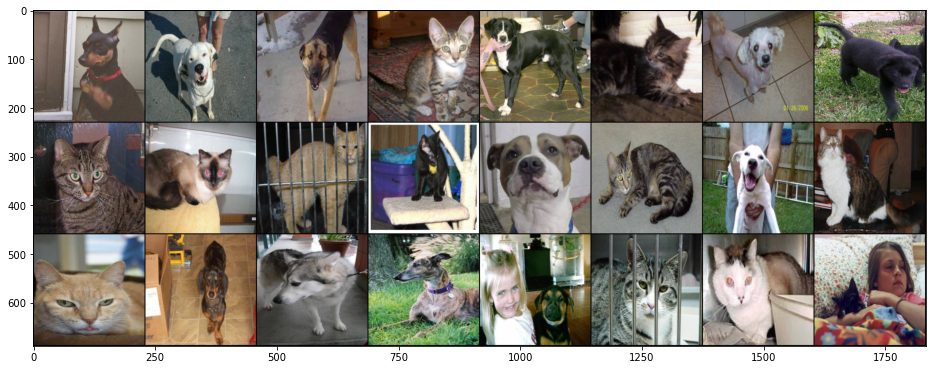

In [316]:
samples, labels = iter(dataloaders['train']).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# SLIDE (2) AlexNet

Ваша задача собрать AlexNet по [картинке](https://github.com/samstikhin/ml2021/blob/master/08-ConvNets/images/alexnet_home.png). 

<img src="images/alexnet_home.png" width=600 />

Дополнения:
* В финальном слое должно быть не 1000 слоев, а всего 2 (так как у нас 2 класса в задаче: Кошки и Собаки)
* Не нужно делать Softmax в конце. Мы будем использовать CrossEntropy далее. Финальный слой: `Linear(4096, 2)`
* После **каждого** слоя `Conv2d` и `Linear` должна стоять активация `ReLU` (кроме финального).
* При переходе от конволюций к линейным слоям нужно использовать слой `Flatten` (который дан в шаблоне), остальные слои берите из модуля `torch.nn`.


# TASK

In [ ]:
from torch import nn

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def get_model():
    return nn.Sequential(
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    )

In [319]:
model = get_model()

assert model[0].kernel_size == (11, 11)
assert model[2].stride == 2
assert model[3].padding == (2,2)
assert model[8].in_channels == 384
assert model[-5].in_features == 256 * 6 * 6
assert model[-3].in_features == 4096
assert model[-1].out_features == 2


for layer in model:
    try:
        layer.weight.data.fill_(0.001)
        layer.bias.data.fill_(0.001)
    except:
        continue

a = torch.ones((1,3,227,227))

assert torch.allclose(model(a), torch.tensor([[3632., 3632.]]), atol=1e-0)


# SLIDE (2) О б у ч е н и е

Ваша задача: используя код из ноутбука ImageNet обучить модель для распознавания котов и собак.
    
В исходном коде нужно:
* поменять кусок с обработкой данных и вставить тот, что делали в дз выше
* заменить модель на AlexNet
* Поменять learning_rate у оптимизатора Adam на 0.0001

Осталось запустить код и дождаться accuracy 0.9 и выше на валидационном сете. На GPU в колаб это должно занять меньше 30 мин.

После обучения модели необходимо прогнать тестовый сет и получить результат в виде одномерного массива с предсказаниями класса объектов. Первые 500 ответов нужно будет скопипастить и отправить в форму юлерна.

`P.S.`

* Не нужно менять CrossEntropy из ноутбука на BCELoss. Профита не получите, но код придется во многих местах менять.

* Не бойтесь останавливать цикл модели. В модели сохранятся последние веса и вы сможете с ее помощью посчитать ответ на тестовом сете.

* Может случиться так, что на первых 5-6 эпохах ничего не происходит - это нормально, алгоритм сделал плохую рандомную инициализацию. За 10 эпох точно должно получиться улучшение. Если после 10 эпох ничего не происходит - перезапустите модель.

* Если вы хотите получить accuracy 0.95 и выше, вам необходимо добавить дропауты в модель, чтобы увеличить ее регуляризацию. Применить [трансформации](https://pytorch.org/vision/stable/transforms.html) к датасетам. Ну и подаждать эпох 50-70:)

# TASK

In [ ]:
def catvsdogs():
    answers = np.array([### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ])
    return answers